# Deep Reinforcement Learning Project
# Team members:
####        Muhammad Maaz Hamid 2022655
####        Wardah Haya 2022622

# Title:
## "Evaluating Deep Q-Learning and Advantage Actor-Critic in a Continuous State Space: A Comparative Analysis in Deep Reinforcement Learning"

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import gymnasium as gym
import flappy_bird_gymnasium
import os
import yaml
from collections import deque
from datetime import datetime, timedelta
import itertools
from IPython.display import clear_output

In [4]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [12]:
# Check for CUDA availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


In [14]:

# Directory for saving run info
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# For printing date and time
DATE_FORMAT = "%m-%d %H:%M:%S"

# Graph update interval (in seconds)
GRAPH_UPDATE_INTERVAL = 5

# Setup and Imports

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import gymnasium as gym
import flappy_bird_gymnasium
import os
import yaml
from collections import deque
from datetime import datetime, timedelta
import itertools
from IPython.display import clear_output

In [3]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


In [7]:
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# For printing date and time
DATE_FORMAT = "%m-%d %H:%M:%S"

# Graph update interval (in seconds)
GRAPH_UPDATE_INTERVAL = 5

# Experience Replay Memory
Implementing the replay memory for DQN:

In [10]:
class ReplayMemory:
    def __init__(self, maxlen, seed=None):
        self.memory = deque([], maxlen=maxlen)
        
        # Optional seed for reproducibility
        if seed is not None:
            random.seed(seed)
            
    def append(self, transition):
        self.memory.append(transition)
        
    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)
    
    def __len__(self):
        return len(self.memory)

# Neural Network Models
### DQN Network

In [13]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, enable_dueling_dqn=True):
        super(DQN, self).__init__()
        
        self.enable_dueling_dqn = enable_dueling_dqn
        
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        
        if self.enable_dueling_dqn:
            # Value stream
            self.fc_value = nn.Linear(hidden_dim, 256)
            self.value = nn.Linear(256, 1)
            
            # Advantages stream
            self.fc_advantages = nn.Linear(hidden_dim, 256)
            self.advantages = nn.Linear(256, action_dim)
            
        else:
            self.output = nn.Linear(hidden_dim, action_dim)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        if self.enable_dueling_dqn:
            # Value calc
            v = F.relu(self.fc_value(x))
            V = self.value(v)
            
            # Advantages calc
            a = F.relu(self.fc_advantages(x))
            A = self.advantages(a)
            
            # Calc Q
            Q = V + A - torch.mean(A, dim=1, keepdim=True)
            
        else:
            Q = self.output(x)
            
        return Q

## A2C Network

In [16]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(ActorCritic, self).__init__()
        
        # Shared feature extractor
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        
        # Actor (policy) head
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
        
        # Critic (value) head
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        features = F.relu(self.fc1(x))
        
        # Policy: categorical distribution over actions
        action_probs = F.softmax(self.actor(features), dim=-1)
        
        # Value: estimated state value
        state_value = self.critic(features)
        
        return action_probs, state_value

## Hyperparameters
##### Let's define our hyperparameters for both DQN and A2C:

In [19]:
# Hyperparameters for DQN
dqn_hyperparameters = {
    "env_id": "FlappyBird-v0",
    "replay_memory_size": 100000,
    "mini_batch_size": 32,
    "epsilon_init": 1.0,
    "epsilon_decay": 0.9995,
    "epsilon_min": 0.05,
    "network_sync_rate": 10,
    "learning_rate_a": 0.0001,
    "discount_factor_g": 0.99,
    "stop_on_reward": 100000,
    "fc1_nodes": 512,
    "env_make_params": {
        "use_lidar": False
    },
    "enable_double_dqn": True,
    "enable_dueling_dqn": True
}

In [21]:
# Hyperparameters for A2C

a2c_hyperparameters = {
    "env_id": "FlappyBird-v0",
    "total_steps":500,
    "learning_rate_a": 0.0003,
    "learning_rate_c": 0.0003,
    "discount_factor_g": 0.99,
    "entropy_coefficient": 0.01,
    "value_loss_coefficient": 0.5,
    "max_grad_norm": 0.5,
    "num_steps": 5,  # Steps per update
    "stop_on_reward": 100000,
    "fc1_nodes": 512,
    "env_make_params": {
        "use_lidar": False
    }
}

## DQN Agent Implementation

In [24]:
class DQNAgent:
    def __init__(self, hyperparameters, run_name="dqn_run"):
        self.hyperparameters = hyperparameters
        self.run_name = run_name
        
        # Hyperparameters
        self.env_id = hyperparameters['env_id']
        self.learning_rate_a = hyperparameters['learning_rate_a']
        self.discount_factor_g = hyperparameters['discount_factor_g']
        self.network_sync_rate = hyperparameters['network_sync_rate']
        self.replay_memory_size = hyperparameters['replay_memory_size']
        self.mini_batch_size = hyperparameters['mini_batch_size']
        self.epsilon_init = hyperparameters['epsilon_init']
        self.epsilon_decay = hyperparameters['epsilon_decay']
        self.epsilon_min = hyperparameters['epsilon_min']
        self.stop_on_reward = hyperparameters['stop_on_reward']
        self.fc1_nodes = hyperparameters['fc1_nodes']
        self.env_make_params = hyperparameters.get('env_make_params', {})
        self.enable_double_dqn = hyperparameters['enable_double_dqn']
        self.enable_dueling_dqn = hyperparameters['enable_dueling_dqn']
        
        # Neural Network
        self.loss_fn = nn.MSELoss()
        self.optimizer = None
        
        # Path to Run info
        self.LOG_FILE = os.path.join(RUNS_DIR, f'{self.run_name}.log')
        self.MODEL_FILE = os.path.join(RUNS_DIR, f'{self.run_name}.pt')
        self.GRAPH_FILE = os.path.join(RUNS_DIR, f'{self.run_name}.png')
        
    def create_environment(self, render=False):
        return gym.make(self.env_id, render_mode='human' if render else None, **self.env_make_params)
    
    def run(self, num_episodes=None, is_training=True, render=False):
        results = {
            'rewards_per_episode': [],
            'epsilon_history': [],
            'loss_history': [],
            'steps_per_episode': []
        }
        
        if is_training:
            start_time = datetime.now()
            last_graph_update_time = start_time
            
            log_message = f"{start_time.strftime(DATE_FORMAT)}: Training starting..."
            print(log_message)
            with open(self.LOG_FILE, 'w') as file:
                file.write(log_message + '\n')
                
        # Create environment
        env = self.create_environment(render)
        
        # Get action space and observation space dimensions
        num_actions = env.action_space.n
        num_states = env.observation_space.shape[0]
        
        # Create policy network
        policy_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)
        
        if is_training:
            # Initialize epsilon
            epsilon = self.epsilon_init
            
            # Initialize replay memory
            memory = ReplayMemory(self.replay_memory_size)
            
            # Create target network
            target_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)
            target_dqn.load_state_dict(policy_dqn.state_dict())
            
            # Set up optimizer
            self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)
            
            # Track steps and best reward
            step_count = 0
            best_reward = -float('inf')
            episode_losses = []
        else:
            # Load saved model for evaluation
            policy_dqn.load_state_dict(torch.load(self.MODEL_FILE))
            policy_dqn.eval()
        
        # Training loop
        total_steps = 0  # Track total environment steps taken
        episode_steps_history = []  # Track steps per episode
        episode_iterator = range(num_episodes) if num_episodes is not None else itertools.count()
        for episode in episode_iterator:
            # Print episode number periodically during training
            if is_training and episode % 10 == 0:
                print(f"Starting episode {episode}...")
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float, device=device)
            
            terminated = False
            episode_reward = 0.0
            episode_losses = []
            
            # Episode loop
            while not terminated and episode_reward < self.stop_on_reward:
                # Select action
                if is_training and random.random() < epsilon:
                    # Random action
                    action = env.action_space.sample()
                    action = torch.tensor(action, dtype=torch.int64, device=device)
                else:
                    # Best action according to policy
                    with torch.no_grad():
                        action = policy_dqn(state.unsqueeze(dim=0)).squeeze().argmax()
                
                # Execute action
                new_state, reward, terminated, truncated, info = env.step(action.item())
                
                # Accumulate rewards
                episode_reward += reward
                
                # Convert to tensors
                new_state = torch.tensor(new_state, dtype=torch.float, device=device)
                reward = torch.tensor(reward, dtype=torch.float, device=device)
                
                if is_training:
                    # Save to replay memory
                    memory.append((state, action, new_state, reward, terminated))
                    
                    # Increment step counter
                    step_count += 1
                    
                    # Training from memory
                    if len(memory) > self.mini_batch_size:
                        loss = self.optimize(memory.sample(self.mini_batch_size), policy_dqn, target_dqn)
                        episode_losses.append(loss)
                        
                        # Sync target network
                        if step_count >= self.network_sync_rate:
                            target_dqn.load_state_dict(policy_dqn.state_dict())
                            step_count = 0
                
                # Move to next state
                state = new_state
            
            # Store episode results
            results['rewards_per_episode'].append(episode_reward)
            results['steps_per_episode'].append(step_count)
            results['steps_per_episode'].append(step_count)
            
            if is_training:
                # Store mean loss if available
                if episode_losses:
                    results['loss_history'].append(np.mean(episode_losses))
                
                # Decay epsilon
                epsilon = max(epsilon * self.epsilon_decay, self.epsilon_min)
                results['epsilon_history'].append(epsilon)
                
                # Log progress
                if (episode + 1) % 10 == 0 or episode_reward > best_reward:
                    log_message = f"{datetime.now().strftime(DATE_FORMAT)}: Episode {episode+1}, Reward: {episode_reward:.1f}, Epsilon: {epsilon:.4f}"
                    if episode_reward > best_reward:
                        log_message += f" (New best! +{episode_reward - best_reward:.1f})"
                        best_reward = episode_reward
                        torch.save(policy_dqn.state_dict(), self.MODEL_FILE)
                    
                    print(log_message)
                    with open(self.LOG_FILE, 'a') as file:
                        file.write(log_message + '\n')
                
                # Update graph periodically
                current_time = datetime.now()
                if current_time - last_graph_update_time > timedelta(seconds=GRAPH_UPDATE_INTERVAL):
                    self.plot_results(results)
                    last_graph_update_time = current_time
        
        # Final graph update
        if is_training:
            self.plot_results(results)
            
        env.close()
        return results
    
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        # Unpack batch
        states, actions, new_states, rewards, terminations = zip(*mini_batch)
        
        # Stack tensors
        states = torch.stack(states)
        actions = torch.stack(actions)
        new_states = torch.stack(new_states)
        rewards = torch.stack(rewards)
        terminations = torch.tensor(terminations).float().to(device)
        
        with torch.no_grad():
            if self.enable_double_dqn:
                # Double DQN: select action using policy network
                best_actions_from_policy = policy_dqn(new_states).argmax(dim=1)
                # But evaluate using target network
                target_q = rewards + (1 - terminations) * self.discount_factor_g * \
                          target_dqn(new_states).gather(dim=1, index=best_actions_from_policy.unsqueeze(dim=1)).squeeze()
            else:
                # Regular DQN: both select and evaluate using target network
                target_q = rewards + (1 - terminations) * self.discount_factor_g * target_dqn(new_states).max(dim=1)[0]
        
        # Current Q values
        current_q = policy_dqn(states).gather(dim=1, index=actions.unsqueeze(dim=1)).squeeze()
        
        # Compute loss
        loss = self.loss_fn(current_q, target_q)
        
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def plot_results(self, results, display=True):
        rewards = results['rewards_per_episode']
        epsilon = results['epsilon_history']
        losses = results['loss_history']
        
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        
        # Plot rewards
        axes[0].set_title('Episode Rewards')
        axes[0].plot(rewards, alpha=0.6, label='Rewards')
        
        # Calculate and plot mean rewards
        mean_rewards = np.zeros(len(rewards))
        for i in range(len(rewards)):
            mean_rewards[i] = np.mean(rewards[max(0, i-99):(i+1)])
        axes[0].plot(mean_rewards, label='Mean Rewards (100 episodes)')
        axes[0].set_xlabel('Episodes')
        axes[0].set_ylabel('Reward')
        axes[0].legend()
        
        # Plot epsilon decay
        if epsilon:
            axes[1].set_title('Epsilon Decay')
            axes[1].plot(epsilon)
            axes[1].set_xlabel('Episodes')
            axes[1].set_ylabel('Epsilon')
            
        # Plot loss
        if losses:
            axes[2].set_title('Training Loss')
            axes[2].plot(losses)
            axes[2].set_xlabel('Episodes')
            axes[2].set_ylabel('Loss')
        
        plt.tight_layout()
        plt.savefig(self.GRAPH_FILE)
        
        if display:
            clear_output(wait=True)
            plt.show()
        else:
            plt.close(fig)

# A2C Agent Implementation

In [27]:
class A2CAgent:
    def __init__(self, hyperparameters, run_name="a2c_run"):
        self.hyperparameters = hyperparameters
        self.run_name = run_name
        
        # Hyperparameters
        self.env_id = hyperparameters['env_id']
        self.learning_rate_a = hyperparameters['learning_rate_a']
        self.learning_rate_c = hyperparameters['learning_rate_c']
        self.discount_factor_g = hyperparameters['discount_factor_g']
        self.entropy_coefficient = hyperparameters['entropy_coefficient']
        self.value_loss_coefficient = hyperparameters['value_loss_coefficient']
        self.max_grad_norm = hyperparameters['max_grad_norm']
        self.num_steps = hyperparameters['num_steps']
        self.stop_on_reward = hyperparameters['stop_on_reward']
        self.fc1_nodes = hyperparameters['fc1_nodes']
        self.env_make_params = hyperparameters.get('env_make_params', {})
        
        # Path to Run info
        self.LOG_FILE = os.path.join(RUNS_DIR, f'{self.run_name}.log')
        self.MODEL_FILE = os.path.join(RUNS_DIR, f'{self.run_name}.pt')
        self.GRAPH_FILE = os.path.join(RUNS_DIR, f'{self.run_name}.png')
    
    def create_environment(self, render=False):
        return gym.make(self.env_id, render_mode='human' if render else None, **self.env_make_params)
    
    def run(self, num_episodes=None, is_training=True, render=False):
        results = {
            'rewards_per_episode': [],
            'policy_loss_history': [],
            'value_loss_history': [],
            'entropy_history': [],
            'steps_per_episode': []
        }
        
        if is_training:
            start_time = datetime.now()
            last_graph_update_time = start_time
            
            log_message = f"{start_time.strftime(DATE_FORMAT)}: A2C Training starting..."
            print(log_message)
            with open(self.LOG_FILE, 'w') as file:
                file.write(log_message + '\n')
        
        # Create environment
        env = self.create_environment(render)
        
        # Get action space and observation space dimensions
        num_actions = env.action_space.n
        num_states = env.observation_space.shape[0]
        
        # Create ActorCritic network
        ac_model = ActorCritic(num_states, num_actions, self.fc1_nodes).to(device)
        
        if is_training:
            # Optimizer for both actor and critic
            optimizer = torch.optim.Adam(ac_model.parameters(), lr=self.learning_rate_a)
            best_reward = -float('inf')
        else:
            # Load saved model for evaluation
            ac_model.load_state_dict(torch.load(self.MODEL_FILE))
            ac_model.eval()
        
        # Training loop
        episode_iterator = range(num_episodes) if num_episodes is not None else itertools.count()
        for episode in episode_iterator:
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float, device=device)
            
            terminated = False
            episode_reward = 0.0
            
            # Lists to store trajectory data
            log_probs = []
            values = []
            rewards = []
            entropies = []
            
            # Episode loop
            step_count = 0
            while not terminated and episode_reward < self.stop_on_reward:
                # Get action probabilities and state value
                action_probs, state_value = ac_model(state.unsqueeze(0))
                
                # Sample action from the distribution
                dist = torch.distributions.Categorical(action_probs)
                action = dist.sample()
                
                # Take action in environment
                next_state, reward, terminated, truncated, _ = env.step(action.item())
                
                # Convert to tensor
                next_state = torch.tensor(next_state, dtype=torch.float, device=device)
                
                # Store trajectory data
                log_prob = dist.log_prob(action)
                entropy = dist.entropy()
                
                log_probs.append(log_prob)
                values.append(state_value)
                rewards.append(reward)
                entropies.append(entropy)
                
                # Update accumulated reward
                episode_reward += reward
                
                # Move to next state
                state = next_state
                
                step_count += 1
                
                # Update model every num_steps or at termination
                if is_training and (step_count % self.num_steps == 0 or terminated):
                    self.update_model(
                        ac_model, 
                        optimizer, 
                        log_probs, 
                        values, 
                        rewards, 
                        entropies, 
                        state if not terminated else None,
                        results
                    )
                    
                    # Clear trajectory data
                    log_probs = []
                    values = []
                    rewards = []
                    entropies = []
            
            # Store episode results
            results['rewards_per_episode'].append(episode_reward)
            total_steps = 500
            if is_training:
                # Log progress
                if (episode + 1) % 10 == 0 or episode_reward > best_reward:
                    log_message = f"{datetime.now().strftime(DATE_FORMAT)}: Episode {episode+1}, Reward: {episode_reward:.1f}, Total Steps: {total_steps}"
                    if episode_reward > best_reward:
                        log_message += f" (New best! +{episode_reward - best_reward:.1f})"
                        best_reward = episode_reward
                        torch.save(ac_model.state_dict(), self.MODEL_FILE)
                    
                    print(log_message)
                    with open(self.LOG_FILE, 'a') as file:
                        file.write(log_message + '\n')
                
                # Update graph periodically
                current_time = datetime.now()
                if current_time - last_graph_update_time > timedelta(seconds=GRAPH_UPDATE_INTERVAL):
                    self.plot_results(results)
                    last_graph_update_time = current_time
        
        # Final graph update
        if is_training:
            self.plot_results(results)
            
        env.close()
        return results
    
    def update_model(self, model, optimizer, log_probs, values, rewards, entropies, next_state, results):
        # Get returns (discounted future rewards)
        returns = self.compute_returns(rewards, next_state, model)
        
        # Convert to tensors
        log_probs = torch.stack(log_probs)
        values = torch.cat(values)
        returns = torch.tensor(returns, dtype=torch.float, device=device)
        entropies = torch.stack(entropies)
        
        # Calculate advantages
        advantages = returns - values.detach()
        
        # Policy loss
        policy_loss = -(log_probs * advantages.detach()).mean()
        
        # Value loss
        value_loss = F.mse_loss(values, returns)
        
        # Entropy (for exploration)
        entropy = entropies.mean()
        
        # Total loss
        loss = policy_loss + self.value_loss_coefficient * value_loss - self.entropy_coefficient * entropy
        
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), self.max_grad_norm)
        
        optimizer.step()
        
        # Store losses
        results['policy_loss_history'].append(policy_loss.item())
        results['value_loss_history'].append(value_loss.item())
        results['entropy_history'].append(entropy.item())
    
    def compute_returns(self, rewards, next_state, model):
        R = 0
        returns = []
        
        # Bootstrap from next state if it exists
        if next_state is not None:
            with torch.no_grad():
                _, next_value = model(next_state.unsqueeze(0))
                R = next_value.item()
        
        # Compute returns in reverse order
        for r in reversed(rewards):
            R = r + self.discount_factor_g * R
            returns.insert(0, R)
        
        return returns
    
    def plot_results(self, results, display=True):
        rewards = results['rewards_per_episode']
        policy_losses = results['policy_loss_history']
        value_losses = results['value_loss_history']
        entropies = results['entropy_history']
        
        fig, axes = plt.subplots(4, 1, figsize=(10, 20))
        
        # Plot rewards
        axes[0].set_title('Episode Rewards')
        axes[0].plot(rewards, alpha=0.6, label='Rewards')
        
        # Calculate and plot mean rewards
        mean_rewards = np.zeros(len(rewards))
        for i in range(len(rewards)):
            mean_rewards[i] = np.mean(rewards[max(0, i-99):(i+1)])
        axes[0].plot(mean_rewards, label='Mean Rewards (100 episodes)')
        axes[0].set_xlabel('Episodes')
        axes[0].set_ylabel('Reward')
        axes[0].legend()
        
        # Plot policy loss
        if policy_losses:
            axes[1].set_title('Policy Loss')
            axes[1].plot(policy_losses)
            axes[1].set_xlabel('Updates')
            axes[1].set_ylabel('Policy Loss')
        
        # Plot value loss
        if value_losses:
            axes[2].set_title('Value Loss')
            axes[2].plot(value_losses)
            axes[2].set_xlabel('Updates')
            axes[2].set_ylabel('Value Loss')
        
        # Plot entropy
        if entropies:
            axes[3].set_title('Entropy')
            axes[3].plot(entropies)
            axes[3].set_xlabel('Updates')
            axes[3].set_ylabel('Entropy')
        
        plt.tight_layout()
        plt.savefig(self.GRAPH_FILE)
        
        if display:
            clear_output(wait=True)
            plt.show()
        else:
            plt.close(fig)

## Training and Evaluation
### Let's implement functions to train and evaluate our agents, and to compare their results.

In [50]:
def train_dqn(episodes=10000):
    """Train a DQN agent"""
    agent = DQNAgent(dqn_hyperparameters, run_name="dqn_flappybird")
    results = agent.run(num_episodes=episodes, is_training=True)
    return agent, results

def train_a2c(episodes=10000):
    """Train an A2C agent"""
    agent = A2CAgent(a2c_hyperparameters, run_name="a2c_flappybird")
    results = agent.run(num_episodes=episodes, is_training=True)
    return agent, results

In [52]:
def evaluate_agent(agent, episodes=100, render=False):
    """Evaluate a trained agent"""
    results = agent.run(num_episodes=episodes, is_training=False, render=render)
    return results

In [54]:
def compare_results(dqn_results, a2c_results, save_path=None):
    """
    Compare the performance of DQN and A2C
    
    Args:
        dqn_results: Results dictionary from DQN training
        a2c_results: Results dictionary from A2C training
        save_path: Path to save comparison graphs (optional)
    """
    dqn_rewards = dqn_results['rewards_per_episode']
    a2c_rewards = a2c_results['rewards_per_episode']
    
    # Create smoothed reward curves (running average)
    dqn_smooth = []
    a2c_smooth = []
    window_size = 100
    
    for i in range(len(dqn_rewards)):
        dqn_smooth.append(np.mean(dqn_rewards[max(0, i-window_size+1):i+1]))
    
    for i in range(len(a2c_rewards)):
        a2c_smooth.append(np.mean(a2c_rewards[max(0, i-window_size+1):i+1]))
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    
    plt.plot(dqn_rewards, alpha=0.3, color='blue', label='DQN Raw')
    plt.plot(dqn_smooth, color='blue', label='DQN Smoothed')
    
    plt.plot(a2c_rewards, alpha=0.3, color='red', label='A2C Raw')
    plt.plot(a2c_smooth, color='red', label='A2C Smoothed')
    
    plt.title('DQN vs A2C Performance Comparison')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    save_path = save_path or os.path.join(RUNS_DIR, 'dqn_vs_a2c_comparison.png')
    plt.savefig(save_path)
    plt.show()
    
    # Calculate statistics
    print(f"DQN Statistics:")
    print(f"  Mean reward: {np.mean(dqn_rewards):.2f}")
    print(f"  Max reward: {np.max(dqn_rewards):.2f}")
    print(f"  Last 100 episodes mean: {np.mean(dqn_rewards[-100:]):.2f}")
    
    print(f"\nA2C Statistics:")
    print(f"  Mean reward: {np.mean(a2c_rewards):.2f}")
    print(f"  Max reward: {np.max(a2c_rewards):.2f}")
    print(f"  Last 100 episodes mean: {np.mean(a2c_rewards[-100:]):.2f}")
    
    # Return results dictionary with comparison metrics
    return {
        "dqn_mean": np.mean(dqn_rewards),
        "dqn_max": np.max(dqn_rewards),
        "dqn_last_100_mean": np.mean(dqn_rewards[-100:]),
        "a2c_mean": np.mean(a2c_rewards),
        "a2c_max": np.max(a2c_rewards),
        "a2c_last_100_mean": np.mean(a2c_rewards[-100:])
    }

# Train both agents

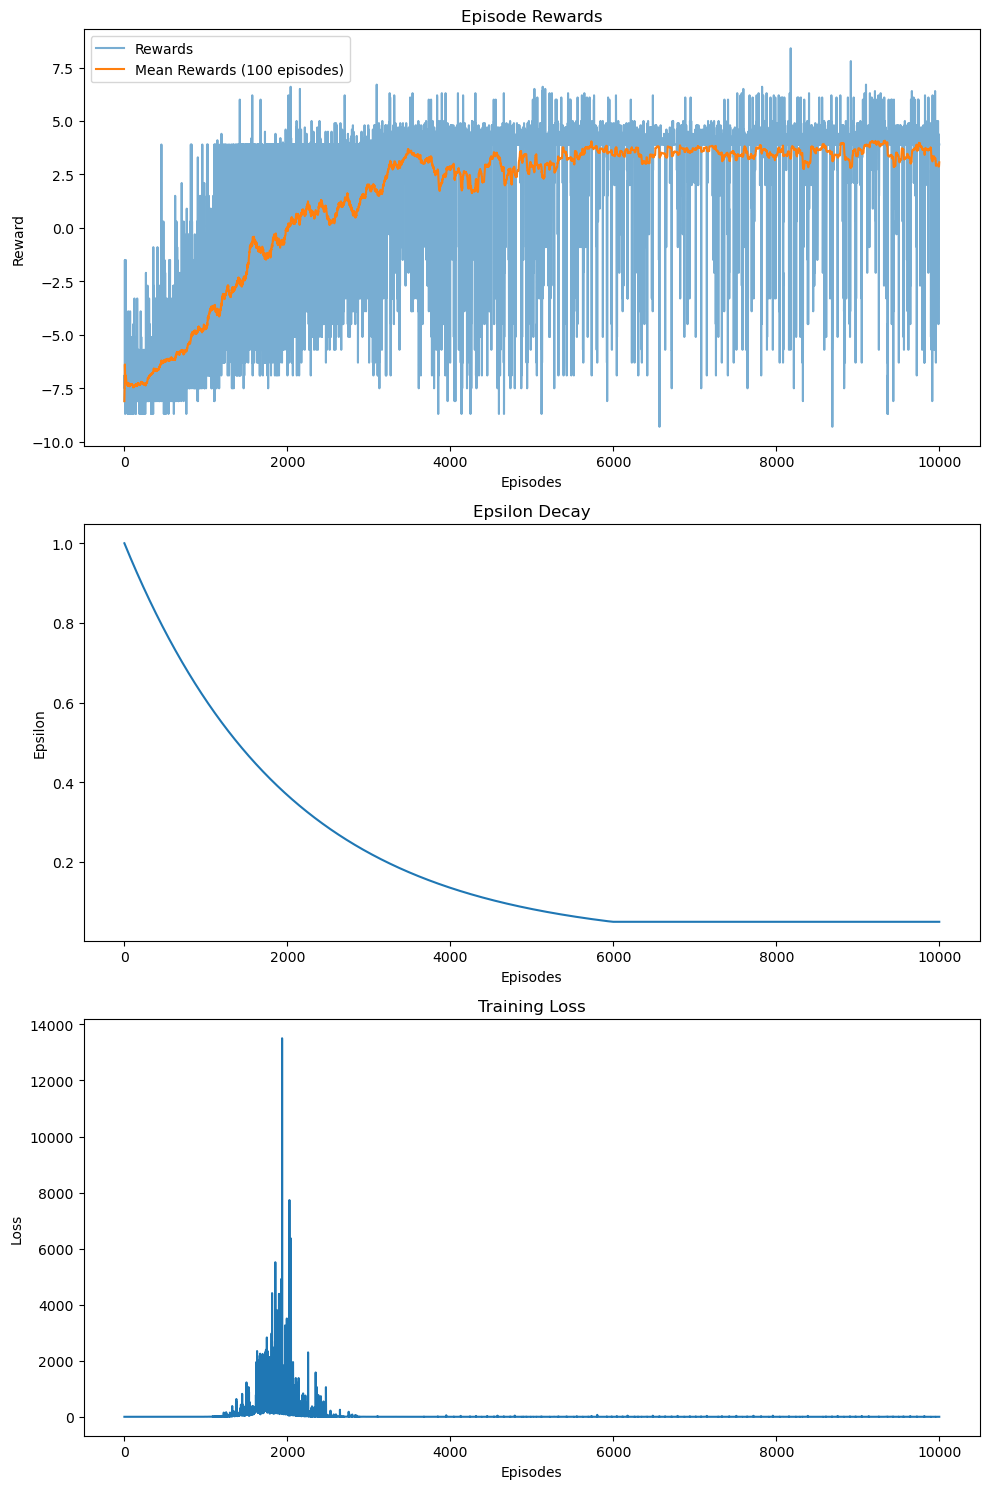

In [57]:
#dqn
print("Training DQN agent...")
dqn_agent, dqn_results = train_dqn()


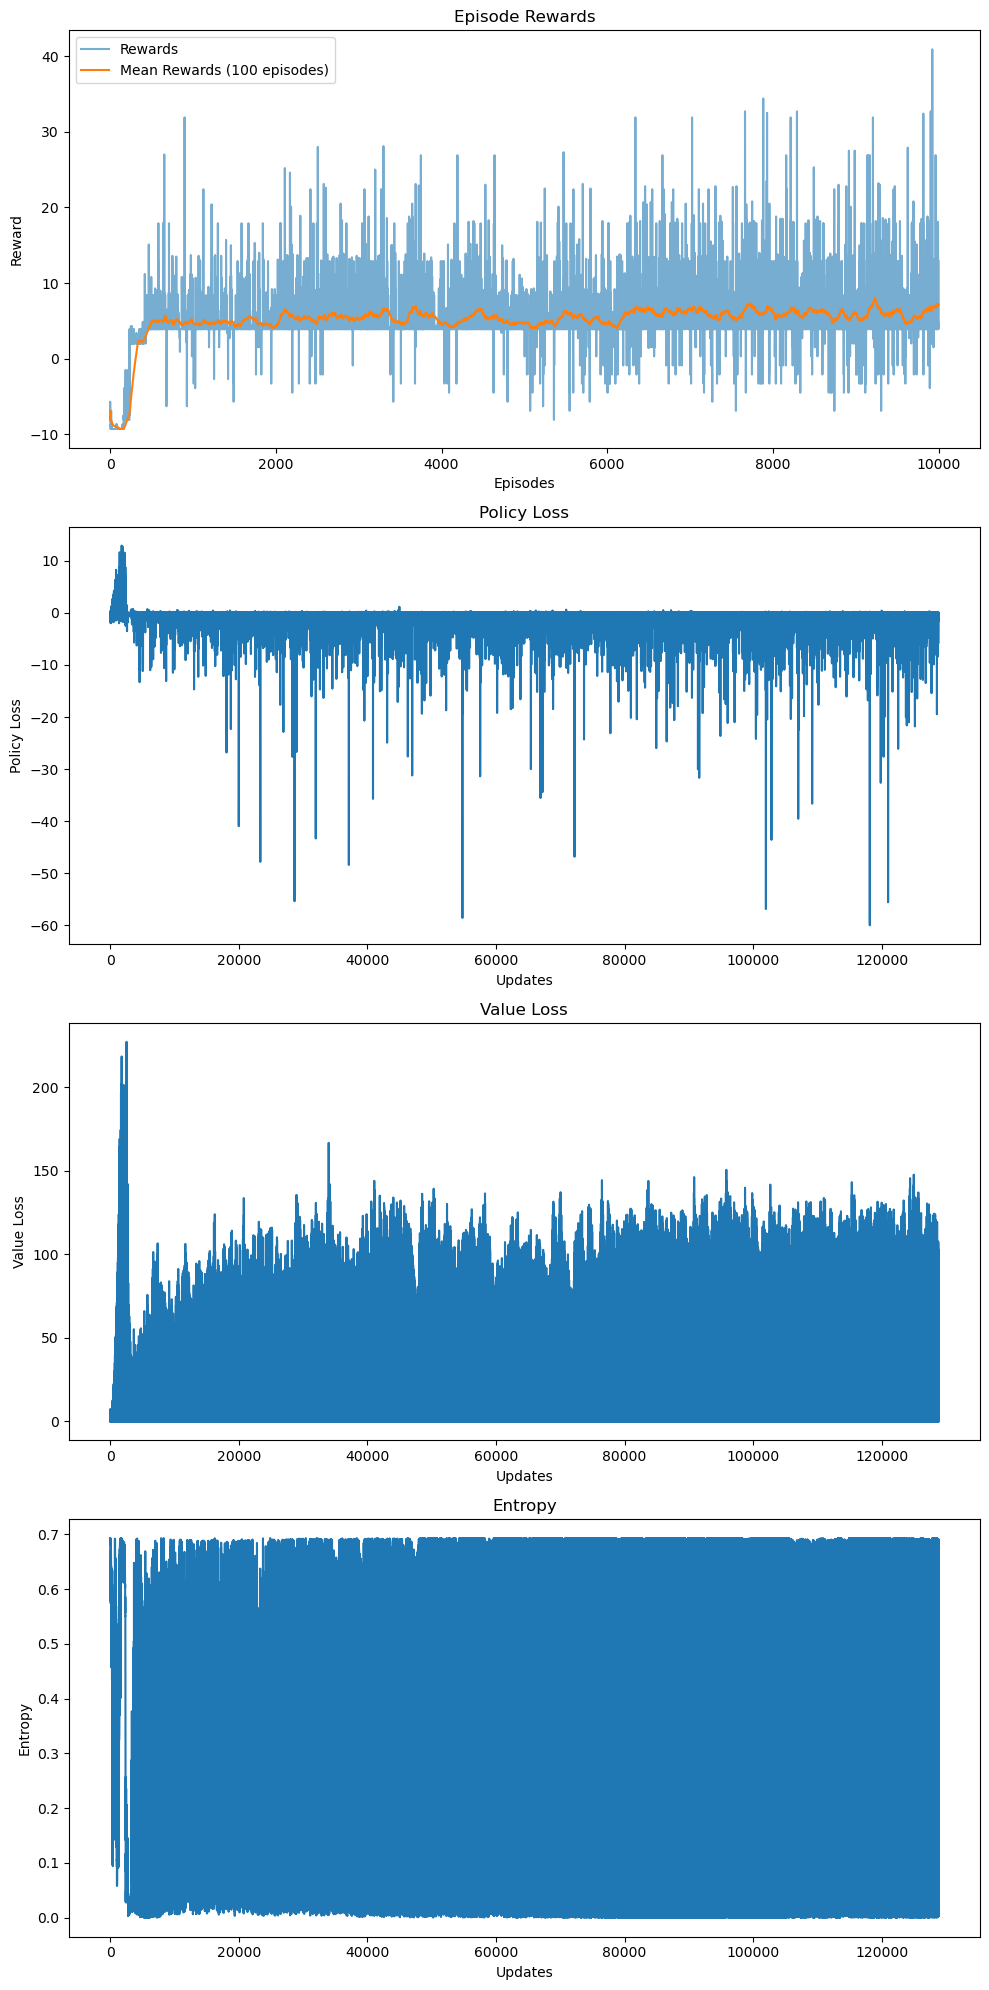

In [59]:
#a2c
print("\nTraining A2C agent...")
a2c_agent, a2c_results = train_a2c()


# Compare the results


Comparing DQN and A2C performance:


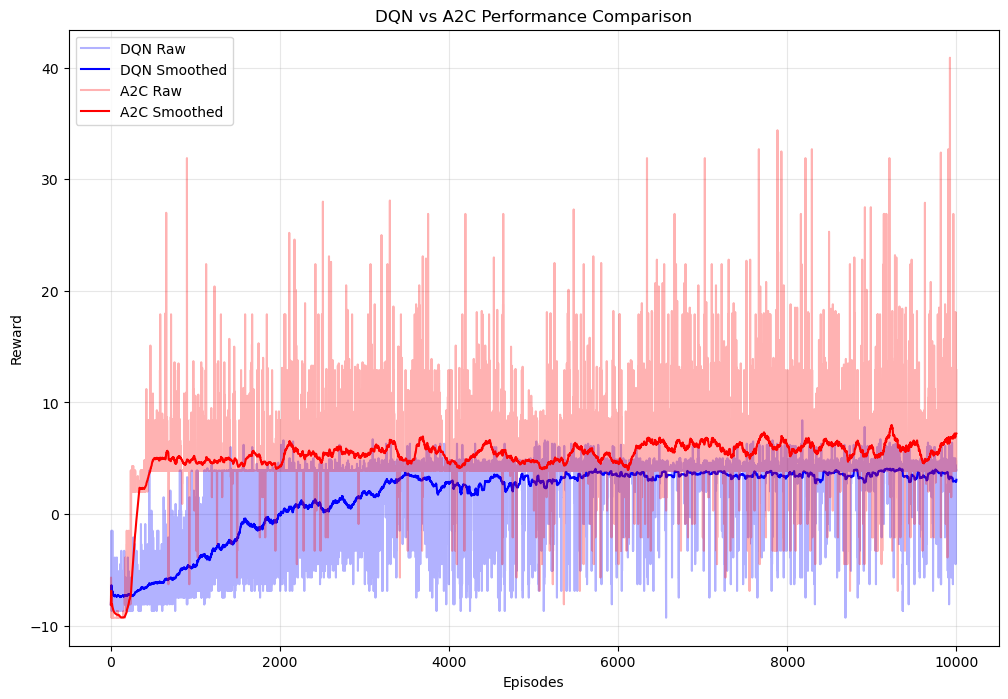

DQN Statistics:
  Mean reward: 1.59
  Max reward: 8.40
  Last 100 episodes mean: 3.07

A2C Statistics:
  Mean reward: 5.13
  Max reward: 40.90
  Last 100 episodes mean: 7.21


In [61]:

print("\nComparing DQN and A2C performance:")
comparison = compare_results(dqn_results, a2c_results)



# Additional analysis: steps per episode comparison

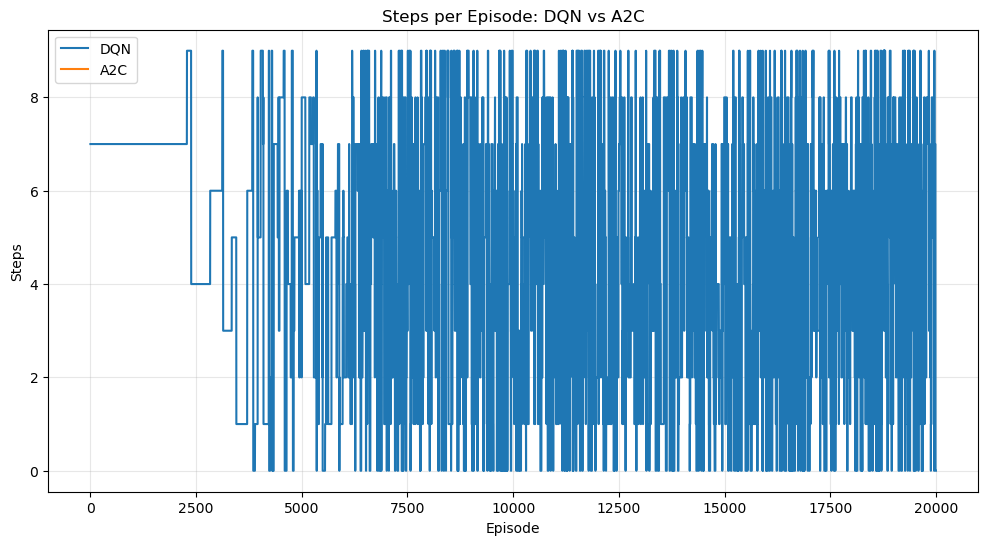

In [63]:

plt.figure(figsize=(12, 6))
plt.plot(dqn_results['steps_per_episode'], label='DQN')
plt.plot(a2c_results['steps_per_episode'], label='A2C')
plt.title('Steps per Episode: DQN vs A2C')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(RUNS_DIR, 'steps_per_episode_comparison.png'))
plt.show()



# Calculate survival efficiency (reward per step)

In [73]:

dqn_efficiency = [r/max(s, 1) for r, s in zip(dqn_results['rewards_per_episode'], dqn_results['steps_per_episode'])]
a2c_efficiency = [r/max(s, 1) for r, s in zip(a2c_results['rewards_per_episode'], a2c_results['steps_per_episode'])]

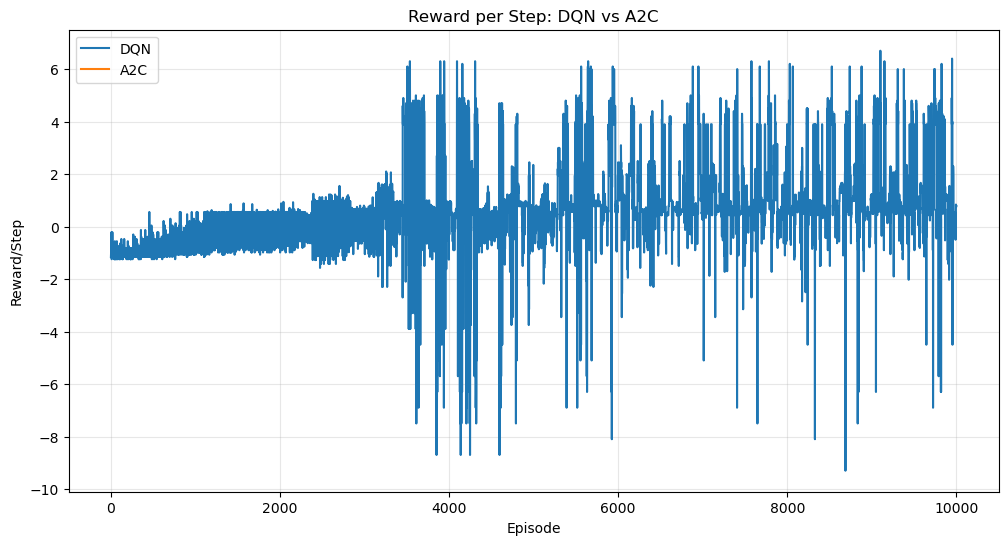

In [69]:

plt.figure(figsize=(12, 6))
plt.plot(dqn_efficiency, label='DQN')
plt.plot(a2c_efficiency, label='A2C')
plt.title('Reward per Step: DQN vs A2C')
plt.xlabel('Episode')
plt.ylabel('Reward/Step')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(RUNS_DIR, 'reward_efficiency_comparison.png'))
plt.show()


# Summary Stats

In [79]:

# Print summary stats
print("\nDQN Average Steps per Episode:", np.mean(dqn_results['steps_per_episode']))
print("\nDQN Average Reward per Step:", np.mean(dqn_efficiency))


DQN Average Steps per Episode: 4.6199

DQN Average Reward per Step: 0.8168879087301584
